In [ ]:
import requests
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your API key in every 24 hours
api_key = "RGAPI-32939235-e54a-4149-a664-156bc7a3a0fe"

def find_summoner_url(player_id):
    api_url = f"https://tr1.api.riotgames.com/lol/summoner/v4/summoners/by-name/{player_id}"
    api_url = f"{api_url}?api_key={api_key}"
    return api_url

def find_puuid(api_url):
    player_info = requests.get(api_url)
    player_info = player_info.json()
    player_puuid = player_info["puuid"]
    return player_puuid

def make_request(url, params):
    while True:
        response = requests.get(url, params=params)

        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:  # Rate limit exceeded (100 request in every 2 minutes)
            print("Rate limit exceeded. Waiting for 10 seconds.")
            time.sleep(10)  # Wait for 2 minutes before retrying
        else:
            print(f"Request failed with status code {response.status_code}. Exiting.")
            break

def get_recent_matches(puuid, startIndex):

    count = 50
    match_url = f"https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start="+ str(startIndex)+"&count="+str(count)
    match_url += f"&api_key={api_key}"

    matches = make_request(match_url, {})

    return matches

player_id = input("Please enter your player ID: ")
summoner_url = find_summoner_url(player_id)
summoner_data = make_request(summoner_url, {})
startIndex = 0
if summoner_data:
    player_puuid = summoner_data["puuid"]
    matches = []
    while startIndex < 1000:
        matches += get_recent_matches(player_puuid, startIndex)
        startIndex += 50

    if matches:
        # Lists to store data for the dataset
        game_start_times = []
        game_end_times = []
        game_durations = []
        game_dates = []

        for match in matches:
            match_api_url = f"https://europe.api.riotgames.com/lol/match/v5/matches/{match}"
            match_api_url += f"?api_key={api_key}"
            match_data = make_request(match_api_url, {})

            match_start_time = datetime.utcfromtimestamp(match_data["info"]["gameStartTimestamp"] / 1000)
            match_end_time = datetime.utcfromtimestamp(match_data["info"]["gameEndTimestamp"] / 1000)
            match_duration = round((match_data["info"]["gameDuration"]) / 60, 2)
            match_date = match_start_time.date()

            game_start_times.append(match_start_time)
            game_end_times.append(match_end_time)
            game_durations.append(match_duration)
            game_dates.append(match_date)

        # Create a pandas DataFrame
        data = {
            'GameStartTime': game_start_times,
            'GameEndTime': game_end_times,
            'GameDuration': game_durations,
            'DateOfGame': game_dates
        }

        df = pd.DataFrame(data)

        # Save the dataset to a CSV file
        df.to_csv('league_of_legends_dataset.csv', index=False)

        # Display the DataFrame
        print(df)




Please enter your player ID: KGAlper


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('league_of_legends_dataset.csv')

# Convert 'DateOfGame' column to datetime format
df['DateOfGame'] = pd.to_datetime(df['DateOfGame'])

# Create a DataFrame with all dates in the desired range
all_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
all_dates_df = pd.DataFrame({'DateOfGame': all_dates})

# Merge the existing DataFrame with the new DataFrame to fill missing dates
merged_df = pd.merge(all_dates_df, df, on='DateOfGame', how='left')

# Replace NaN values with 0 for playtime
merged_df['GameDuration'] = merged_df['GameDuration'].fillna(0)

# Group by date and calculate total playtime for each day
daily_playtime = merged_df.groupby('DateOfGame')['GameDuration'].sum()

# Convert playtime to hours and round to 2 digits
daily_playtime_hours = (daily_playtime / 60).round(2)

# Iterate through the DataFrame and print each row with formatted date
print("Daily Playtime in Hours:")
for index, value in daily_playtime_hours.items():
    formatted_date = index.strftime('%Y-%m-%d')
    print(f"{formatted_date}: {value} hours")


Daily Playtime in Hours:
2023-01-01: 1.26 hours
2023-01-02: 2.59 hours
2023-01-03: 1.08 hours
2023-01-04: 0.41 hours
2023-01-05: 0.43 hours
2023-01-06: 2.12 hours
2023-01-07: 1.91 hours
2023-01-08: 0.8 hours
2023-01-09: 1.24 hours
2023-01-10: 2.46 hours
2023-01-11: 3.39 hours
2023-01-12: 3.75 hours
2023-01-13: 5.9 hours
2023-01-14: 6.72 hours
2023-01-15: 1.61 hours
2023-01-16: 0.0 hours
2023-01-17: 0.0 hours
2023-01-18: 0.0 hours
2023-01-19: 0.0 hours
2023-01-20: 0.0 hours
2023-01-21: 0.0 hours
2023-01-22: 0.0 hours
2023-01-23: 0.0 hours
2023-01-24: 5.99 hours
2023-01-25: 6.85 hours
2023-01-26: 3.08 hours
2023-01-27: 4.86 hours
2023-01-28: 4.09 hours
2023-01-29: 5.75 hours
2023-01-30: 4.05 hours
2023-01-31: 5.89 hours
2023-02-01: 1.04 hours
2023-02-02: 1.74 hours
2023-02-03: 3.82 hours
2023-02-04: 1.49 hours
2023-02-05: 1.68 hours
2023-02-06: 0.8 hours
2023-02-07: 0.0 hours
2023-02-08: 0.0 hours
2023-02-09: 0.0 hours
2023-02-10: 3.49 hours
2023-02-11: 4.16 hours
2023-02-12: 1.21 hours


<ipython-input-6-afd58ff2c1af>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resampled = df.resample('D').sum().fillna(0)


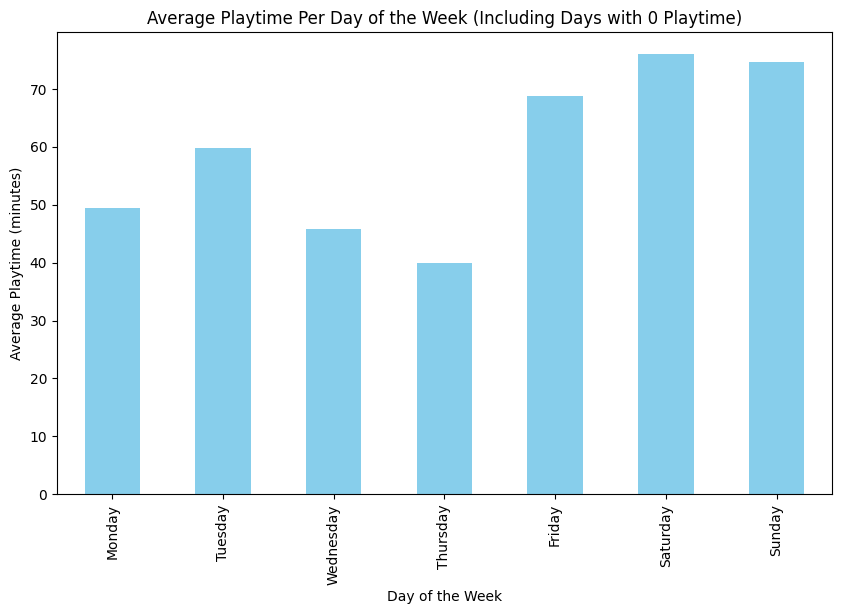

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('league_of_legends_dataset.csv')

# Convert 'DateOfGame' column to datetime format
df['DateOfGame'] = pd.to_datetime(df['DateOfGame'])

# Set 'DateOfGame' as the index
df.set_index('DateOfGame', inplace=True)

# Resample the data to include all days, filling NaN values with 0
df_resampled = df.resample('D').sum().fillna(0)

# Calculate playtime per day
df_resampled['DayOfWeek'] = df_resampled.index.day_name()

# Order the days of the week starting from Monday
weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
playtime_per_day = df_resampled.groupby('DayOfWeek')['GameDuration'].mean().reindex(weekdays_order)

# Plotting
plt.figure(figsize=(10, 6))
playtime_per_day.plot(kind='bar', color='skyblue')
plt.title('Average Playtime Per Day of the Week (Including Days with 0 Playtime)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Playtime (minutes)')
plt.show()


<ipython-input-12-6a35199b3e98>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resampled = df_2023.resample('D').sum().fillna(0)


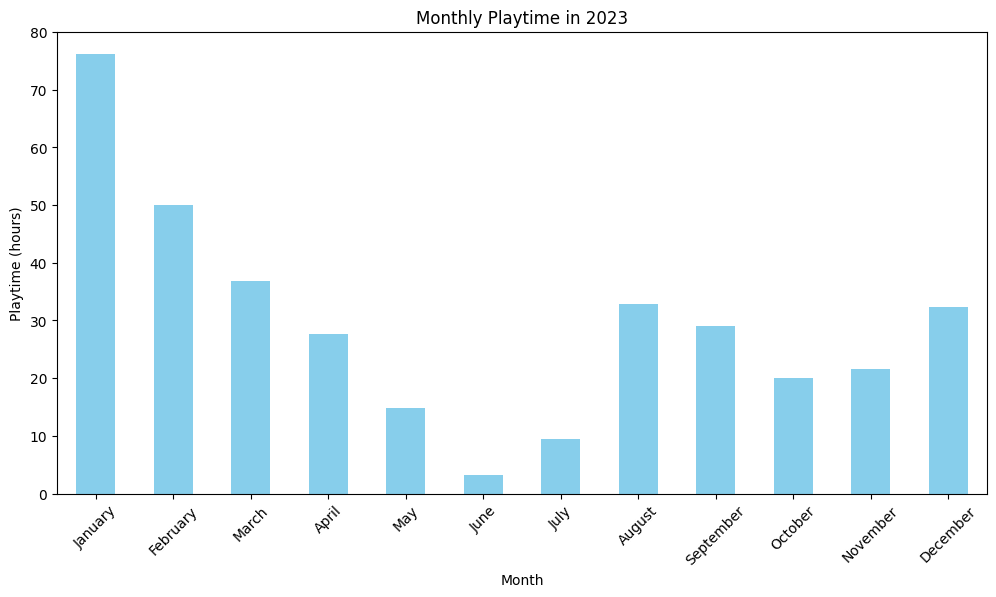

In [ ]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('league_of_legends_dataset.csv')

# Convert 'DateOfGame' column to datetime format
df['DateOfGame'] = pd.to_datetime(df['DateOfGame'])

# Filter data for the year 2023
df_2023 = df[(df['DateOfGame'] >= '2023-01-01') & (df['DateOfGame'] < '2024-01-01')]

# Set 'DateOfGame' as the index
df_2023.set_index('DateOfGame', inplace=True)

# Resample the data to include all days, filling NaN values with 0
df_resampled = df_2023.resample('D').sum().fillna(0)

# Calculate playtime per day
df_resampled['MonthYear'] = df_resampled.index.to_period('M')
df_resampled['MonthName'] = df_resampled.index.month_name()

# Calculate monthly playtime
monthly_playtime = (df_resampled.groupby(['MonthYear', 'MonthName'])['GameDuration'].sum())/60

# Plotting
plt.figure(figsize=(12, 6))
monthly_playtime.plot(kind='bar', color='skyblue')
plt.title('Monthly Playtime in 2023')
plt.xlabel('Month')
plt.ylabel('Playtime (hours)')
plt.xticks(range(len(monthly_playtime.index)), monthly_playtime.index.get_level_values('MonthName'), rotation=45)
plt.show()


<ipython-input-63-7cb0107a12a5>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resampled = df_2023.resample('D').sum().fillna(0)
<ipython-input-63-7cb0107a12a5>:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_resampled['WeekNumber'] = df_resampled.index.week


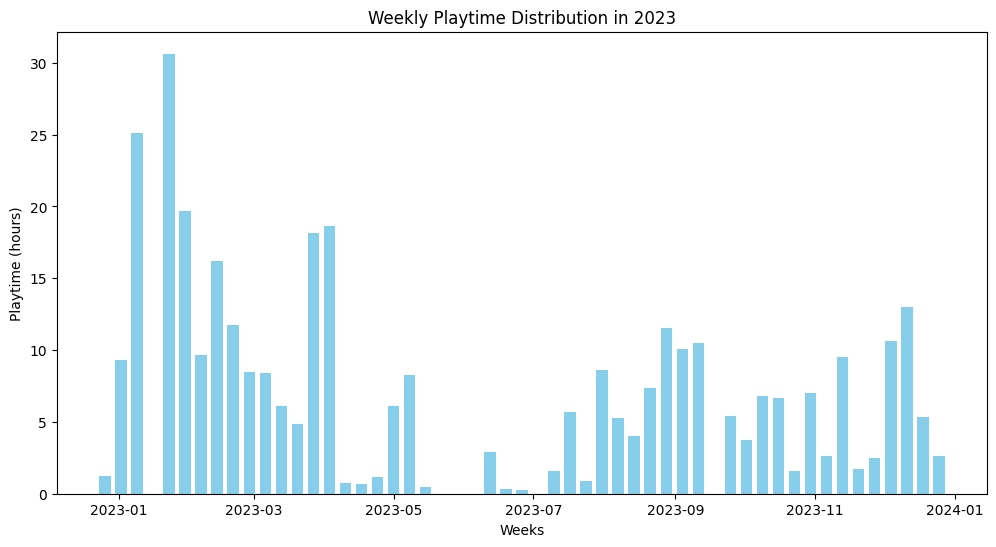

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('league_of_legends_dataset.csv')

# Convert 'DateOfGame' column to datetime format
df['DateOfGame'] = pd.to_datetime(df['DateOfGame'])

# Filter data for the year 2023
df_2023 = df[(df['DateOfGame'] >= '2023-01-01') & (df['DateOfGame'] < '2024-01-01')]

# Set 'DateOfGame' as the index
df_2023.set_index('DateOfGame', inplace=True)

# Resample the data to include all days, filling NaN values with 0
df_resampled = df_2023.resample('D').sum().fillna(0)

# Calculate playtime per day
df_resampled['WeekNumber'] = df_resampled.index.week
df_resampled['WeekStart'] = df_resampled.index - pd.to_timedelta(df_resampled.index.weekday, unit='D')
df_resampled['WeekEnd'] = df_resampled['WeekStart'] + pd.DateOffset(days=6)
weekly_playtime = df_resampled.groupby(['WeekNumber', 'WeekStart', 'WeekEnd'])['GameDuration'].sum()

# Filter weeks in 2023
weekly_playtime = (weekly_playtime / 60).round(2)

# Plotting as a simple bar graph
plt.figure(figsize=(12, 6))
plt.bar(
    x=weekly_playtime.index.get_level_values('WeekStart'),
    height=weekly_playtime,
    width=5,
    color='skyblue'
)
plt.title('Weekly Playtime Distribution in 2023')
plt.xlabel('Weeks')
plt.ylabel('Playtime (hours)')

plt.show()


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('league_of_legends_dataset.csv')

# Convert 'DateOfGame' column to datetime format
df['DateOfGame'] = pd.to_datetime(df['DateOfGame'])

# Filter data for the year 2023
df_2023 = df[(df['DateOfGame'] >= '2023-01-01') & (df['DateOfGame'] < '2024-01-01')]

# Set 'DateOfGame' as the index
df_2023.set_index('DateOfGame', inplace=True)

# Resample the data to include all days, filling NaN values with 0
df_resampled = df_2023.resample('D').sum().fillna(0)

# Calculate playtime per day
df_resampled['WeekNumber'] = df_resampled.index.week
df_resampled['WeekStart'] = df_resampled.index - pd.to_timedelta(df_resampled.index.weekday, unit='D')
df_resampled['WeekEnd'] = df_resampled['WeekStart'] + pd.DateOffset(days=6)
weekly_playtime = df_resampled.groupby(['WeekNumber', 'WeekStart', 'WeekEnd'])['GameDuration'].sum()

# Filter weeks in 2023
weekly_playtime = weekly_playtime[weekly_playtime.index.get_level_values('WeekStart').year == 2023]
weekly_playtime = (weekly_playtime / 60).round(2)
# Find the top 5 weeks with the most playtime
top_5_weeks = weekly_playtime.nlargest(5)
bottom_10_weeks = weekly_playtime.nsmallest(10)
# Display the top 5 weeks with the most playtime
print("Top 5 Weeks with Most Playtime:")
print(top_5_weeks)

# Display the bottom 10 weeks with the least playtime
print("Bottom 10 Weeks with Least Playtime:")
print(bottom_10_weeks)


Top 5 Weeks with Most Playtime:
WeekNumber  WeekStart   WeekEnd   
4           2023-01-23  2023-01-29    30.63
2           2023-01-09  2023-01-15    25.09
5           2023-01-30  2023-02-05    19.71
14          2023-04-03  2023-04-09    18.65
13          2023-03-27  2023-04-02    18.17
Name: GameDuration, dtype: float64
Bottom 10 Weeks with Least Playtime:
WeekNumber  WeekStart   WeekEnd   
3           2023-01-16  2023-01-22    0.00
21          2023-05-22  2023-05-28    0.00
22          2023-05-29  2023-06-04    0.00
23          2023-06-05  2023-06-11    0.00
27          2023-07-03  2023-07-09    0.00
38          2023-09-18  2023-09-24    0.00
26          2023-06-26  2023-07-02    0.27
25          2023-06-19  2023-06-25    0.32
20          2023-05-15  2023-05-21    0.50
16          2023-04-17  2023-04-23    0.69
Name: GameDuration, dtype: float64


<ipython-input-64-911c013ea6a4>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resampled = df_2023.resample('D').sum().fillna(0)
<ipython-input-64-911c013ea6a4>:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_resampled['WeekNumber'] = df_resampled.index.week


In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('league_of_legends_dataset.csv')

# Convert 'DateOfGame' column to datetime format
df['DateOfGame'] = pd.to_datetime(df['DateOfGame'])

# Create a DataFrame with all dates in the desired range
all_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
all_dates_df = pd.DataFrame({'DateOfGame': all_dates})

# Merge the existing DataFrame with the new DataFrame to fill missing dates
merged_df = pd.merge(all_dates_df, df, on='DateOfGame', how='left')

# Replace NaN values with 0 for playtime
merged_df['GameDuration'] = merged_df['GameDuration'].fillna(0)

# Group by date and calculate total playtime for each day
daily_playtime = merged_df.groupby('DateOfGame')['GameDuration'].sum()

# Calculate the mean daily playtime
mean_daily_playtime = daily_playtime.mean()

print(f"Mean Daily Playtime: {mean_daily_playtime / 60:.2f} hours")


Mean Daily Playtime (including days with 0 playtime): 0.97 hours
